Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# MONAI for PyTorch users
This tutorial briefly introduces MONAI APIs and highlights its flexibility and usability. It assumes basic understanding of PyTorch, and shows how MONAI provide domain-optimized capabilities for deep learning in healthcare imaging.

## Setup environment

MONAI's core functionality is written in Python and only depends on Numpy and Pytorch.

This section installs the latest version of MONAI and verifies the installation.

In [1]:
# install the latest weekly preview version of MONAI
!python -c "import monai" || pip install -q "monai-weekly[tqdm, nibabel, gdown, ignite]"

## Setup imports

In [ ]:
import monai.transforms as mt
import logging
import sys
import matplotlib.pyplot as plt
import ignite
import numpy as np
import torch
import monai
import warnings

warnings.filterwarnings("ignore")  # remove some scikit-image warnings


logging.basicConfig(stream=sys.stdout, level=logging.INFO)
monai.config.print_config()

## Access public medical imaging dataset in a few lines of code
Using a publicly available benchmark is important for open and reproducible research. MONAI aims at providing quick access to the well-known public datasets. This section starts a dataset of [Medical Segmentation Decathlon](http://medicaldecathlon.com/).

The `DecathlonDataset` object is a thin wrapper of `torch.data.utils.Dataset`. 
It has  `__getitem__` and `__len__` methods implemented, fully compatible with Pytorch's build-in data loader `torch.data.utils.DataLoader`.

Compared with the PyTorch `Dataset` APIs, `DecathlonDataset` has the additional capabilities of
- automatic downloading and unzipping data
- caching of data as well as intermediate results of preprocessing
- random splits of training, validation, and test 


In [3]:
dataset = monai.apps.DecathlonDataset(
    root_dir="./", task="Task05_Prostate", section="training", transform=None, download=True
)
print(f"\nnumber of subjects: {len(dataset)}")
print(f"The first element in the dataset is\n{dataset[0]}.")

2023-02-22 12:42:35,803 - INFO - Verified 'Task05_Prostate.tar', md5: 35138f08b1efaef89d7424d2bcc928db.
2023-02-22 12:42:35,804 - INFO - File exists: Task05_Prostate.tar, skipped downloading.
2023-02-22 12:42:35,805 - INFO - Non-empty folder exists in Task05_Prostate, skipped extracting.


Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 44456.54it/s]


number of subjects: 26
The first element in the dataset is
{'image': 'Task05_Prostate/imagesTr/prostate_46.nii.gz', 'label': 'Task05_Prostate/labelsTr/prostate_46.nii.gz'}.


The code section has created a `DecathlonDataset` object by downloading "Task05_Prostate.tar" (`download=True`) from the public repository, unzipping it, and parsing the JSON file provided by the archive.

This is a three-class segmentation task for delineating prostate transitional zone and peripheral zone (background, TZ, PZ classes).  The input has two modalities, that is, T2 and ADC MRI.

`len(dataset)` and `dataset[0]` queries the size of the dataset, and fetches the first element of the dataset respectively.  As we haven't specified any image transforms for the dataset, the outputs of this iterable dataset are just pairs of image and segmentation file names.

## Flexible image data transformations
This section introduces MONAI transforms that convert the file names into data arrays in memory, which will be ready to be consumed by the deep learning models. More examples on the pre-processing pipelines are available in the [tutorials repository](https://github.com/Project-MONAI/tutorials):

- [3d_image_transforms](3d_image_transforms.ipynb)
- [transforms_update_meta_data](transforms_update_meta_data.ipynb)
- [integrate_3rd_party_transforms](integrate_3rd_party_transforms.ipynb)

Here we briefly cover the main features for image pre-processing.

### Array vs. Dictionary-based transforms

Array transforms are basic building blocks in MONAI, it is a simple callable similar to `torchvision.transforms`. Except for two differences:
- MONAI transforms implements medical imaging specific processing functionality
- MONAI transforms assumes that the inputs are numpy array, pytorch tensors or tensor-like objects

The following starts a loader transform which converts a filename string into the actual image data.

Please refer to [the documentation for more options](https://docs.monai.io/en/latest/transforms.html#monai.transforms.LoadImage) to this transform.

In [4]:
loader = mt.LoadImage(image_only=True)
img_array = loader("Task05_Prostate/imagesTr/prostate_02.nii.gz")
print(img_array.shape)

torch.Size([320, 320, 24, 2])


Dictionary transforms are nothing but wrappers of the array versions. Compared with their array-based counterparts, it's easier to apply the same type of operations or states to multiple data inputs.

The following section reads a pair of image and segmentation mask, note that the `keys` need to be specified, so that the transforms know which items in the dictionary should be processed.

In [5]:
dict_loader = mt.LoadImageD(keys=("image", "label"))
data_dict = dict_loader(
    {"image": "Task05_Prostate/imagesTr/prostate_02.nii.gz", "label": "Task05_Prostate/labelsTr/prostate_02.nii.gz"}
)
print(f"image shape: {data_dict['image'].shape}, \nlabel shape: {data_dict['label'].shape}")

image shape: torch.Size([320, 320, 24, 2]), 
label shape: torch.Size([320, 320, 24])


By default, `LoadImage` returns a MONAI `MetaTensor` instance, which is a subclass of PyTorch Tensor.

MONAI is in a unique position, leveraging the most advanced machine learning libraries, 
and focusing on medical image domain-specific features. `MetaTensor` is the core data structure, making the medical image metadata loosely coupled with image array data in a deep learning pipeline.

MetaTensor is highly interoperable across Numpy and PyTorch APIs by design, and is supported by all MONAI transforms. For more information please see the tutorials:

- [transforms_metatensor](transforms_metatensor.ipynb)

### Compose the transforms

In many cases, it is beneficial to build a chain of transforms, tuning the preprocessing parameters, making fast preprocessing pipelines. `monai.transforms.Compose` is designed for these use cases.

The following code starts a transform chain to do multiple pre-processing steps:
- Load Nifti images (with image meta-data information)
- Make both image and label channel-first (reshape the image and add a channel dimension for the label)
- Make both image and label 1 millimeter isotropic
- Make both image and label to be in the "RAS" coordinate system
- Scale the image intensities
- Resize both image and label to spatial size (64, 64, 32)-millimeters
- Randomly rotate and scale the image, but keep the output size to be (64, 64, 32)-mm

In [6]:
KEYS = ("image", "label")

xform = mt.Compose(
    [
        mt.LoadImageD(KEYS),
        mt.EnsureChannelFirstD("image"),
        mt.AddChannelD("label"),
        mt.OrientationD(KEYS, axcodes="RAS"),
        mt.SpacingD(KEYS, pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        mt.ScaleIntensityD(keys="image"),
        mt.ResizeD(KEYS, (64, 64, 32), mode=("trilinear", "nearest")),
        mt.RandAffineD(
            KEYS,
            spatial_size=(-1, -1, -1),
            rotate_range=(0, 0, np.pi / 2),
            scale_range=(0.1, 0.1),
            mode=("bilinear", "nearest"),
            prob=1.0,
        ),
    ]
)

data_dict = xform(
    {"image": "Task05_Prostate/imagesTr/prostate_02.nii.gz", "label": "Task05_Prostate/labelsTr/prostate_02.nii.gz"}
)
print(data_dict["image"].shape, data_dict["label"].shape)

torch.Size([2, 64, 64, 32]) torch.Size([1, 64, 64, 32])


There are a set of useful transforms in MONAI, and many more to come.
Please find out the details at https://docs.monai.io/en/latest/transforms.html

## Dataset, transform, and data loader
To recap what we have:
- Dataset: a thin wrapper of `torch.utils.data.Dataset`
- Transform: a callable, can be a part of a transform chain made by `Compose`
- Setting transforms to a dataset, will enable the data loading and preprocessing pipeline

The pipeline can work with the pytorch native data loader, which provides multi-processing support and flexible batch sampling schemes.

However, it is recommended to work with the MONAI data loader `monai.data.DataLoader`, which is a wrapper of the pytorch native. MONAI data loader mainly adds the capabilities of:
- properly handling randomized augmentations in the multi-process contexts
- customized collate functions to flatten multi-sample data list into individual training samples

*The initialization of `DecathlonDataset` involves caching the (non-randomizable) transforms' results. It seems to be slow, but when using the initialized object for a training of multiple epochs, we effectively trade the space for much improved speed.*

In [7]:
# start a chain of transforms
xform = mt.Compose(
    [
        mt.LoadImageD(KEYS, image_only=True),
        mt.EnsureChannelFirstD("image"),
        mt.AddChannelD("label"),
        mt.OrientationD(KEYS, axcodes="RAS"),
        mt.SpacingD(KEYS, pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        mt.ScaleIntensityD(keys="image"),
        mt.ResizeD(KEYS, (64, 64, 32), mode=("trilinear", "nearest")),
        mt.RandAffineD(
            KEYS,
            spatial_size=(-1, -1, -1),
            rotate_range=(0, 0, np.pi / 2),
            scale_range=(0.1, 0.1),
            mode=("bilinear", "nearest"),
            prob=1.0,
        ),
    ]
)
# start a dataset
dataset = monai.apps.DecathlonDataset(
    root_dir="./", task="Task05_Prostate", section="training", transform=xform, download=True
)

# start a pytorch dataloader
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=1)
data_loader = monai.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)

2023-02-22 12:42:37,152 - INFO - Verified 'Task05_Prostate.tar', md5: 35138f08b1efaef89d7424d2bcc928db.
2023-02-22 12:42:37,153 - INFO - File exists: Task05_Prostate.tar, skipped downloading.
2023-02-22 12:42:37,154 - INFO - Non-empty folder exists in Task05_Prostate, skipped extracting.


Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:11<00:00,  2.31it/s]


Take a peek at what's happening in the `data_dict` (rerun the following section will generate randomly augmented samples from the dataset):

torch.Size([1, 2, 64, 64, 32]) torch.Size([1, 1, 64, 64, 32]) ['Task05_Prostate/imagesTr/prostate_18.nii.gz']


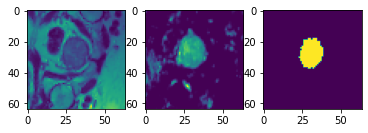

unique labels: [0. 1.]


In [8]:
data_dict = next(iter(data_loader))
print(data_dict["image"].shape, data_dict["label"].shape, data_dict["image"].meta["filename_or_obj"])

plt.subplots(1, 3)
plt.subplot(1, 3, 1)
plt.imshow(data_dict["image"][0, 0, ..., 16])
plt.subplot(1, 3, 2)
plt.imshow(data_dict["image"][0, 1, ..., 16])
plt.subplot(1, 3, 3)
plt.imshow(data_dict["label"][0, 0, ..., 16])
plt.show()

print(f"unique labels: {np.unique(data_dict['label'])}")

The data loader has added a batch dimension to both image and label, so that they are ready for the deep learning models.

Because "nearest" interpolation mode is used for the label, the number of unique classes is preserved during the transforms.

## Layers, blocks, networks and loss functions

We've gone through the data input pipeline. the properly preprocessed data are ready for the 3-class segmentation task using two modalities inputs.

This section creates a UNet model, as well as a loss function and optimizer. 

All these modules are direct uses or extensions of the PyTorch interfaces (such as `torch.nn.Module`). They could be replaced by any customized Python code, as long as the code also follows the standard PyTorch APIs.

MONAI's modules focus on providing enhanced modules for medical images analysis:
- implements reference networks with the aims of both flexibility and code readability
- predefined layers and blocks which are compatible with 1D, 2D and 3D networks
- domain-specific loss functions

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=monai.networks.layers.Norm.BATCH,
).to(device)
loss = monai.losses.DiceLoss(to_onehot_y=True, softmax=True)
opt = torch.optim.Adam(net.parameters(), 1e-2)

`UNet` is defined with a `dimensions` parameter. It specifies the number of spatial dimensions of the pytorch APIs, such as Conv1d, Conv2d and Conv3d. With the same implementation, it could be easily configured for 1D, 2D, 3D, and multi-modal training.

`UNet` as an extension of `torch.nn.Module` is a set of MONAI blocks and layers organized in a specific way. The blocks and layers, such as commonly used combinations of "Conv. + Feature Norm. + Activation", are designed as reusable submodules.

## Sliding window inference
For this commonly used module, MONAI provides a simple PyTorch based implementation, which only requires specifications of window size and a input model (which could be a `torch.nn.Module` implementation).

The following demo shows you a toy of sliding window inference on an input image of (1, 1, 200, 200) by aggregating (40, 40) spatial size windows running through all the spatial locations.

You can change the `roi_size`, `sw_batch_size`, and `overlap` parameters to see their impacts on the sliding window outputs.

In [10]:
class ToyModel:
    # A simple model generates the output by adding an integer `pred` to input.
    # each call of this instance increases the integer by 1.
    pred = 0

    def __call__(self, input):
        self.pred = self.pred + 1
        input = input + self.pred
        return input


infer = monai.inferers.SlidingWindowInferer(roi_size=(40, 40), sw_batch_size=1, overlap=0)
input_tensor = torch.zeros(1, 1, 200, 200)
output_tensor = infer(input_tensor, ToyModel())

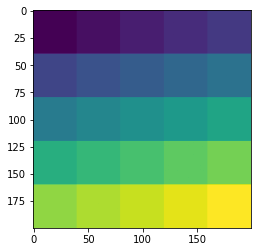

In [11]:
plt.imshow(output_tensor[0, 0])
plt.show()

## Start a training workflow (with validations at every epoch)

The input pipeline, network architectures, loss functions are all compatible with any existing pytorch-based workflow. Please see the tutorials for different use cases:
https://github.com/Project-MONAI/tutorials

- [Array-based U-Net training example](../3d_segmentation/torch/unet_training_array.py)
- [Dict-based U-Net training example](../3d_segmentation/torch/unet_training_dict.py)


Here we would like to highlight the workflow utilities, built by MONAI based on PyTorch-Ignite.  The main goal is to reduce user's efforts when building relatively standard training workflows.

In [12]:
print(ignite.__version__)

0.4.10


The following commands will start a `SupervisedTrainer` instance. As an extension of Pytorch ignite's facilities, it combines all the elements mentioned before. Calling `trainer.run()` will train the network for two epochs and compute `MeadDice` metric based on the training data at the end of every epoch.

The `key_train_metric` is used to track the progress of model quality improvement. Additional handlers could be set to do early stopping and learning rate scheduling.

The `StatsHandler` is triggered at each training iteration, to print diagnostic information to stdout.  These could be configured to generate detailed training logs at a user-specified frequency.

For more information about the event handling system, please refer to the documentation https://docs.monai.io/en/latest/handlers.html.

It is worth noting that these features facilitate fast prototyping of regular training and validation pipelines.  The users can always choose to build their own pipelines, benefiting from the modules mentioned in the previous sections.

In [ ]:
trainer = monai.engines.SupervisedTrainer(
    device=device,
    max_epochs=2,
    train_data_loader=data_loader,
    network=net,
    optimizer=opt,
    loss_function=loss,
    # inferer=monai.inferers.SlidingWindowInferer((32, 32, -1), sw_batch_size=2),  # optionally using a sw inferer
    postprocessing=mt.AsDiscreteD(keys=["pred", "label"], argmax=(True, False), to_onehot=3),
    key_train_metric={
        "train_meandice": monai.handlers.MeanDice(output_transform=monai.handlers.from_engine(["pred", "label"]))
    },
    train_handlers=monai.handlers.StatsHandler(
        tag_name="train_loss", output_transform=monai.handlers.from_engine(["loss"], first=True)
    ),
)
trainer.run()

## Deterministic training
Deterministic training support is important for reproducible research.
MONAI currently provides two mechanisms:

1. set the random state of all the random transforms. This will not affect the global random state. For example:
```python
# define a transform chain for pre-processing
train_transforms = monai.transforms.Compose([
    LoadImaged(keys=['image', 'label']),
    RandRotate90d(keys=['image', 'label'], prob=0.2, spatial_axes=[0, 2]),
    ... ...
])
# set determinism for reproducibility
train_transforms.set_random_state(seed=0)
```

2. enable deterministic training globally for python, numpy and pytorh in one line of code, for example:
``` 
monai.utils.set_determinism(seed=0, additional_settings=None)
```

## Summary

We have walked through the major modules in MONAI. By making highly flexible extensions and wrappers, MONAI enhances the pytorch APIs from a medical image analysis perspective.

For details of our latest milestone highlights, please visit https://docs.monai.io/en/latest/highlights.html.

To dive into MONAI, the tutorials repository is a good starting point https://github.com/Project-MONAI/tutorials.

For API documentation, please visit https://docs.monai.io/en/stable/api.html.